## Importing Libraries

In [1]:
import pandas as pd
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import discrete_allocation
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import base_optimizer
from pypfopt.discrete_allocation import DiscreteAllocation
from pypfopt.hierarchical_portfolio import HRPOpt

C:\Users\ruchd\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ruchd\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\ruchd\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Getting the Data 2010 July till 2020 June

In [2]:
# Define the ticker list
tickers_list = ['AAPL', 'WMT', 'MU', 'BA','GOOG','GE','AMD','BAC','T','UAA','XOM','RRC','PFE','JPM','SBUX']

#BABA & GM removed as no data available for 2010

start_date ='2010-7-1'
end_date ='2015-6-30'

# Fetch the data
import yfinance as yf
data = yf.download(tickers_list,start = start_date,end = end_date)['Adj Close']
#print(data.iloc[-1])
# Print first 5 rows of the data
print(data.head())
#print(data.tail())

[*********************100%***********************]  15 of 15 completed
                AAPL   AMD         BA        BAC         GE       GOOG  \
Date                                                                     
2010-07-01  7.542634  7.39  49.130009  11.610365  63.055862  10.946221   
2010-07-02  7.495889  7.17  48.877499  11.461304  61.984123  10.872995   
2010-07-06  7.547189  7.04  48.419807  11.643487  62.386013  10.861040   
2010-07-07  7.851955  7.39  49.950676  12.181772  65.288734  11.212971   
2010-07-08  7.834349  7.37  51.079109  12.305991  66.226517  11.371377   

                  JPM        MU       PFE        RRC      SBUX         T  \
Date                                                                       
2010-07-01  25.559065  8.278521  8.364992  38.114773  9.845168  6.967657   
2010-07-02  25.381973  8.120458  8.312085  37.593285  9.721405  6.953341   
2010-07-06  25.736170  8.248882  8.400263  37.356255  9.425971  6.987691   
2010-07-07  27.025455  8.78234

## Markowitz with Sharpe maximization

In [3]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
historical_prices = data

# Calculate expected returns
returns = expected_returns.mean_historical_return(historical_prices)
cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
ef = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))

# add a secondary objective
#ef.add_objective(objective_functions.L2_reg)

# Efficient Frontier with random portfolios

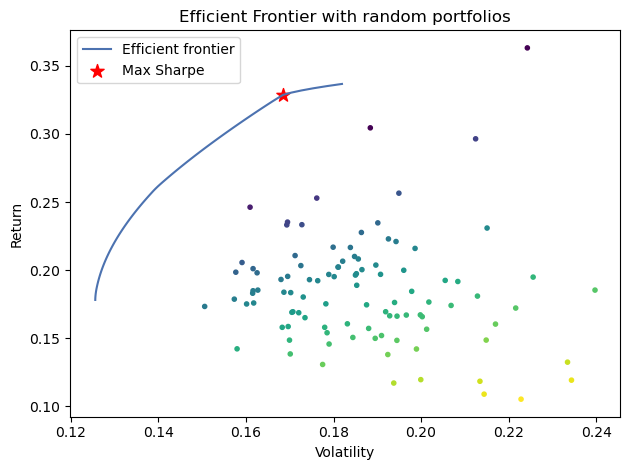

In [4]:
import pypfopt.plotting as plotting
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 100
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
#plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [5]:
# Optimize for maximum Sharpe ratio

#weights = ef.max_sharpe()

#  print weights
cleaned_weights = ef_max_sharpe.clean_weights()
print(cleaned_weights)

OrderedDict([('AAPL', 0.2), ('AMD', 0.0), ('BA', 0.0), ('BAC', 0.0), ('GE', 0.0), ('GOOG', 0.0), ('JPM', 0.0), ('MU', 0.0), ('PFE', 0.2), ('RRC', 0.0), ('SBUX', 0.2), ('T', 0.2), ('UAA', 0.2), ('WMT', 0.0), ('XOM', 0.0)])


In [6]:
#to know the expected performance of the portfolio with optimal weights w
ef_max_sharpe.portfolio_performance(verbose=True)

Expected annual return: 32.9%
Annual volatility: 16.9%
Sharpe Ratio: 1.83


(0.32888224089218376, 0.16855257155408965, 1.8325572730467738)

In [7]:
# Calculate the discrete allocation of assets based on the optimal weights
latest_prices = historical_prices.iloc[-1]  # Latest prices for the assets
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.greedy_portfolio()

In [8]:
print("Optimal Allocation:", allocation)
print("Leftover:",leftover)

Optimal Allocation: {'AAPL': 71, 'PFE': 84, 'SBUX': 44, 'T': 135, 'UAA': 48}
Leftover: 1.1269474029541016


[*********************100%***********************]  1 of 1 completed


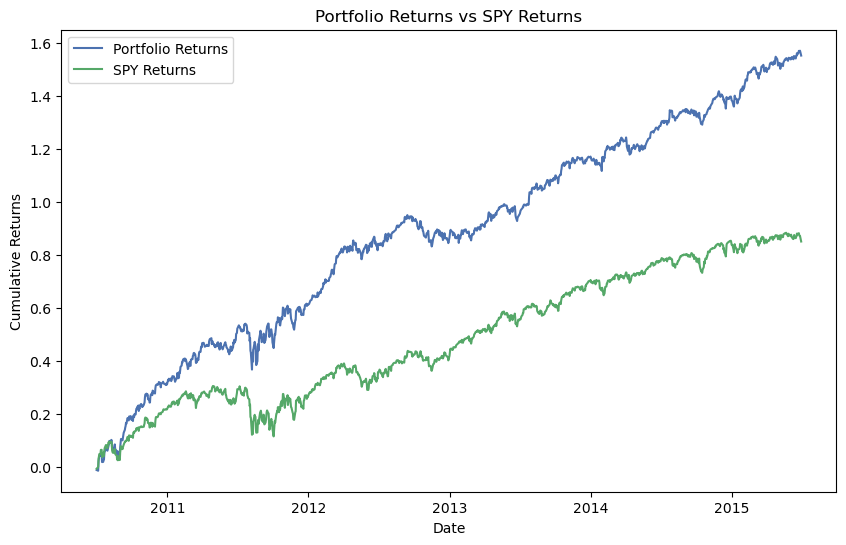

In [9]:
# Download benchmark data
spy_data = yf.download('SPY', start=start_date, end=end_date)['Adj Close']

# Calculate portfolio and benchmark returns
portfolio_returns = (historical_prices.pct_change().dropna() * cleaned_weights).sum(axis=1)
benchmark_returns = spy_data.pct_change().dropna()

# Plot the returns
plt.figure(figsize=(10, 6), facecolor='none')
plt.plot(portfolio_returns.cumsum(), label='Portfolio Returns')
plt.plot(benchmark_returns.cumsum(), label='SPY Returns')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Returns vs SPY Returns')
# Remove background grid lines
plt.grid(visible=False)
#plt.savefig('portfolio_vs_spy.png', transparent=True)

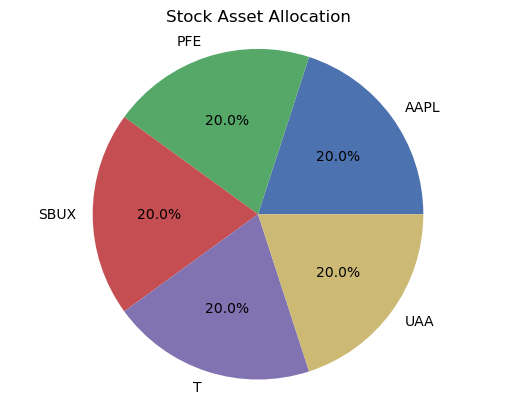

In [10]:
filtered_dict = {key: value for key, value in cleaned_weights.items() if value != 0}
labels = list(filtered_dict.keys()) 
values = list(filtered_dict.values())
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title('Stock Asset Allocation')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Testing on data from July 2020 to June 2023 with monthly rebalancing in empyrial. 

Start date: 2015-7-01
End date: 2020-06-30


,Backtest
,
Annual return,6.75%
Cumulative return,68.51%
Annual volatility,21.63 %
Winning day ratio,53.08%
Sharpe ratio,0.41
Calmar ratio,0.17
Information ratio,-0.0
Stability,0.82
Max Drawdown,-39.01 %


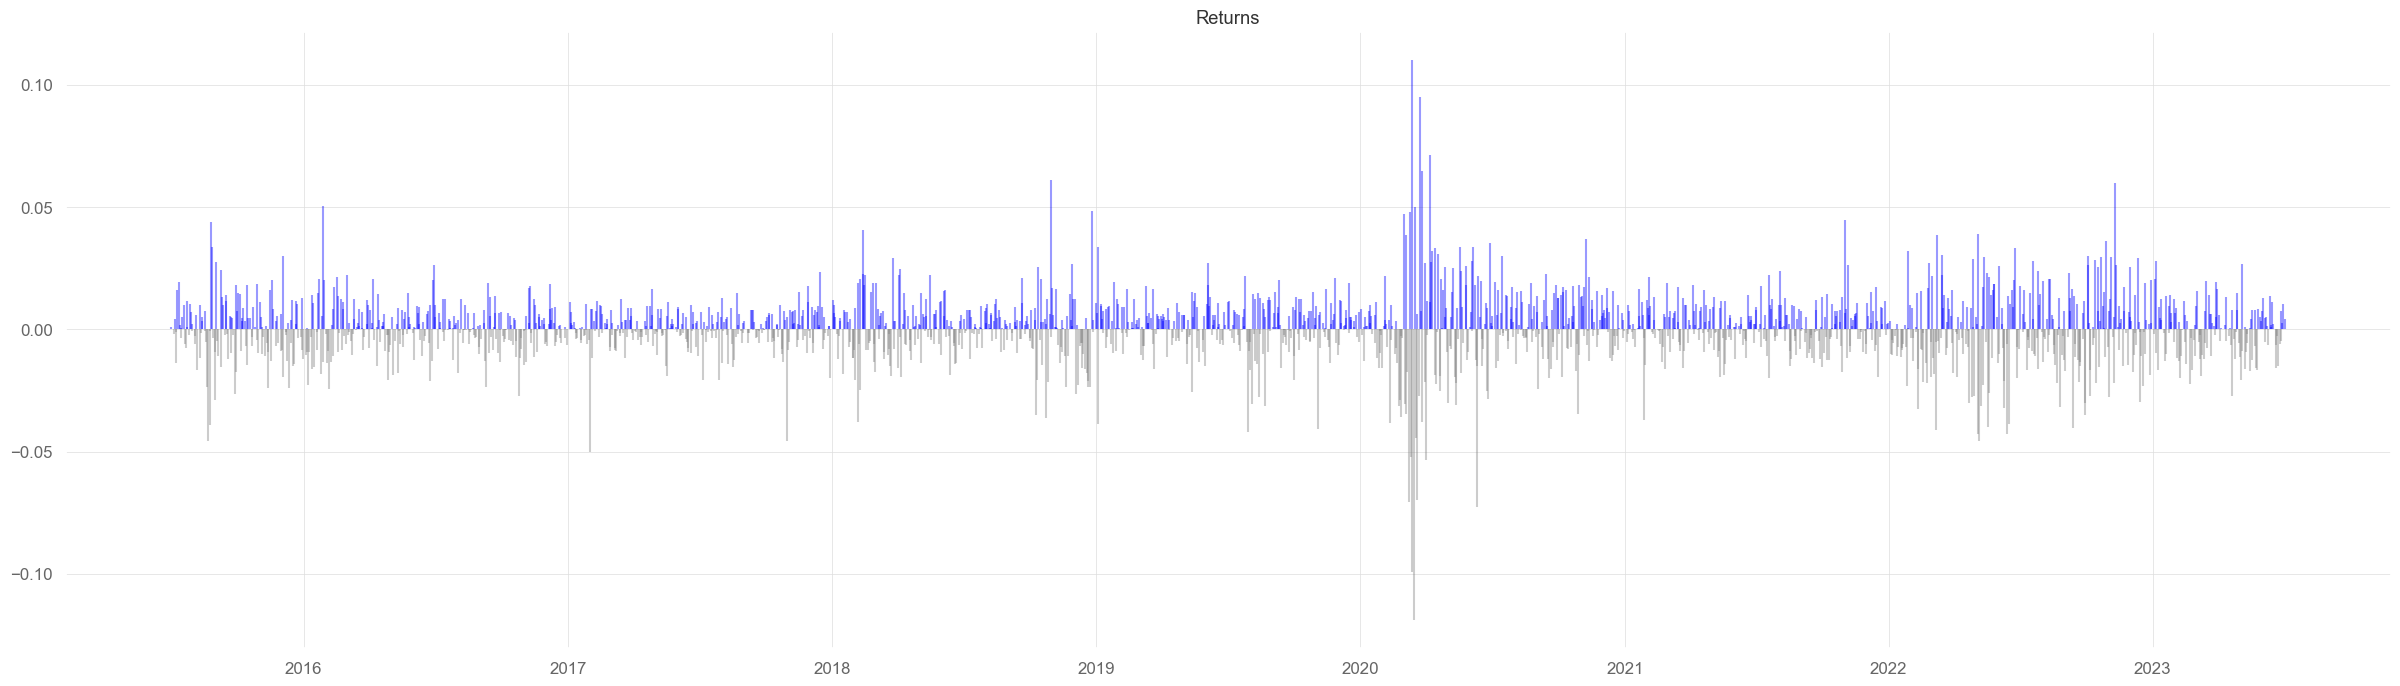

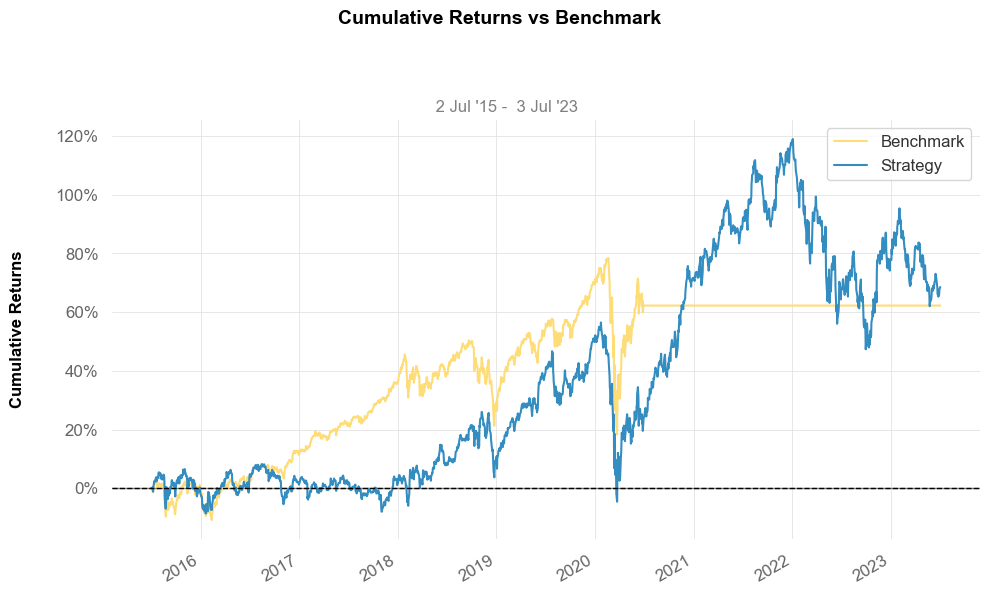

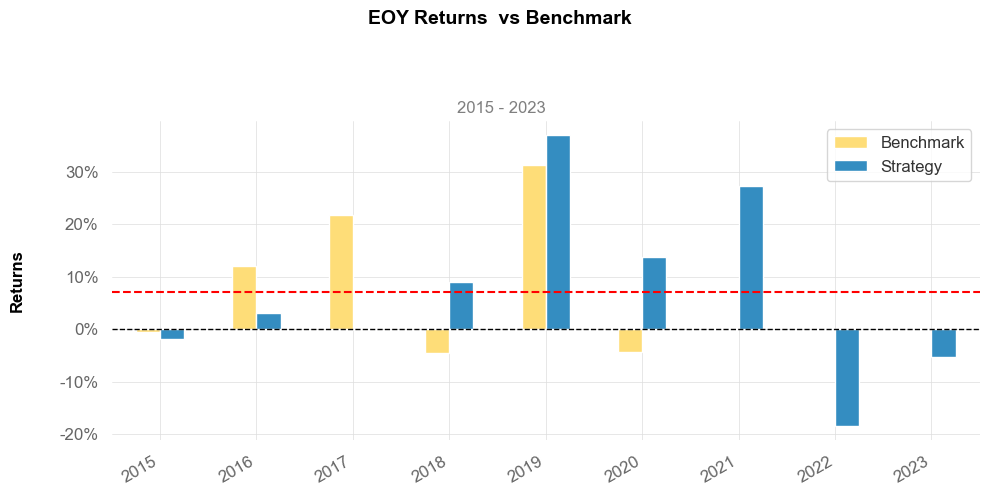

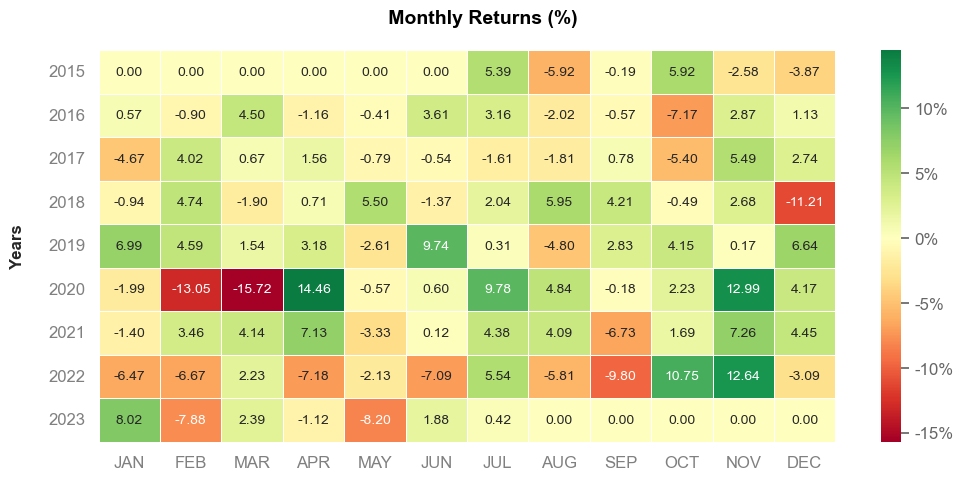

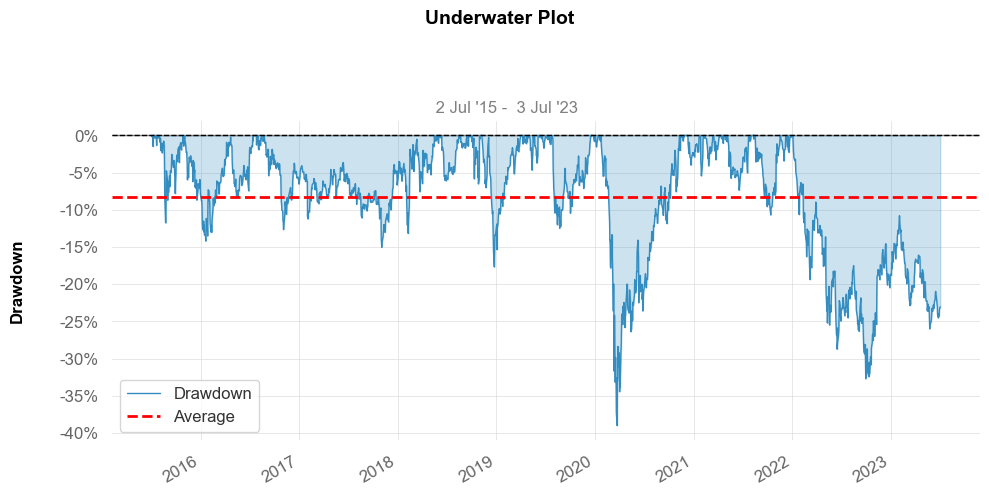

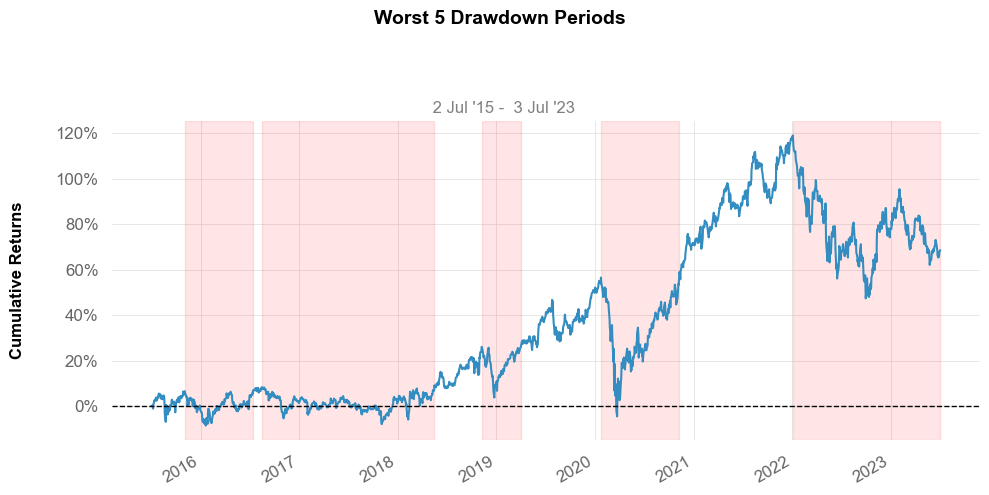

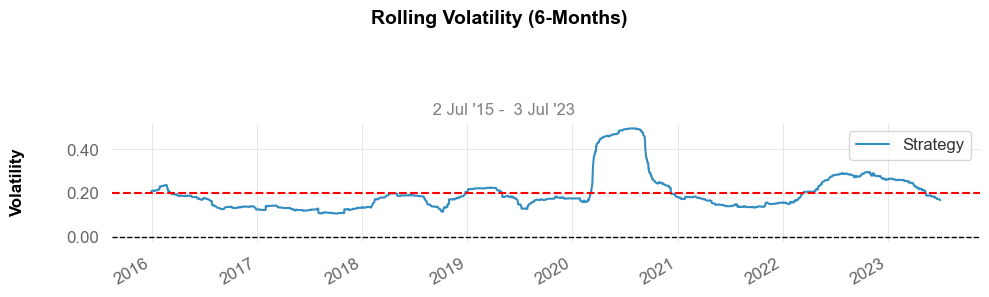

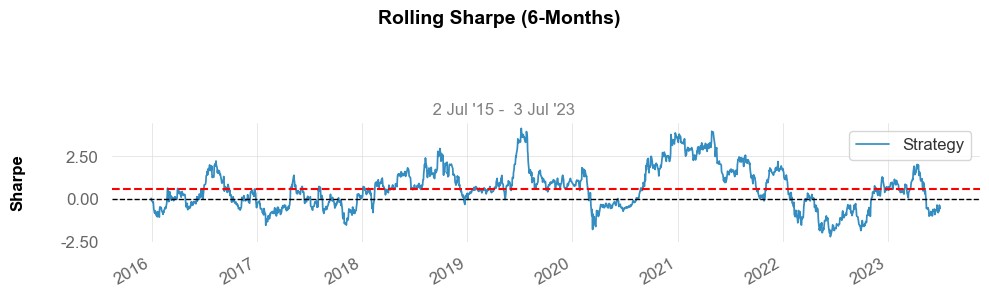

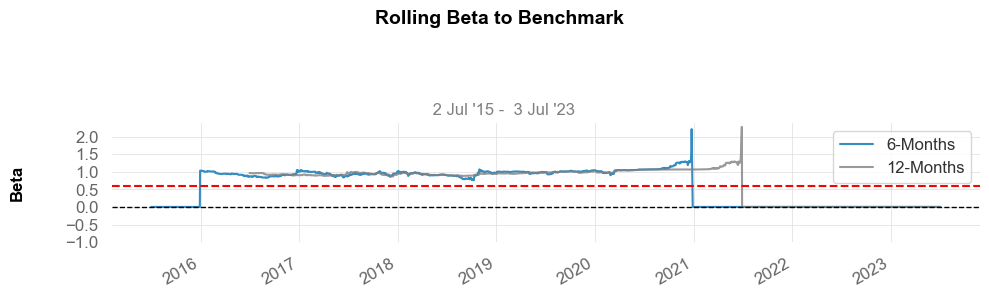

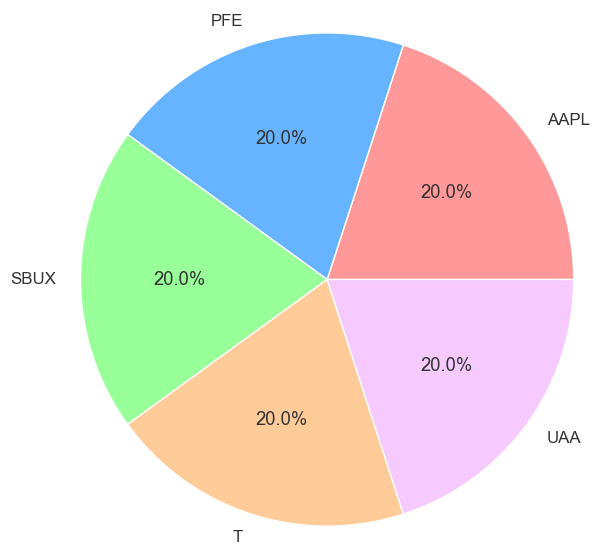

(None, None, None, None, None, None, None, None, None)

In [11]:
portfolio_tickers = list(cleaned_weights.keys()) 
portfolio_weights = list(cleaned_weights.values())

import datetime
from empyrial import empyrial, Engine
portfolio = Engine(
      start_date = "2015-7-01",
      #optimizer = "MEANVAR",
      end_date=datetime.date(2020, 6, 30),
      #max_weights=0.2,
      #max_vol = 0.20,
      rebalance = "2y",
      portfolio = portfolio_tickers,
      weights = portfolio_weights,
      benchmark = ["SPY"]
)
#portfolio.weights

empyrial(portfolio)

Start date: 2020-7-01
End date: 2023-06-30


,Backtest
,
Annual return,10.92%
Cumulative return,35.8%
Annual volatility,20.56 %
Winning day ratio,51.34%
Sharpe ratio,0.61
Calmar ratio,0.35
Information ratio,-0.0
Stability,0.11
Max Drawdown,-30.24 %


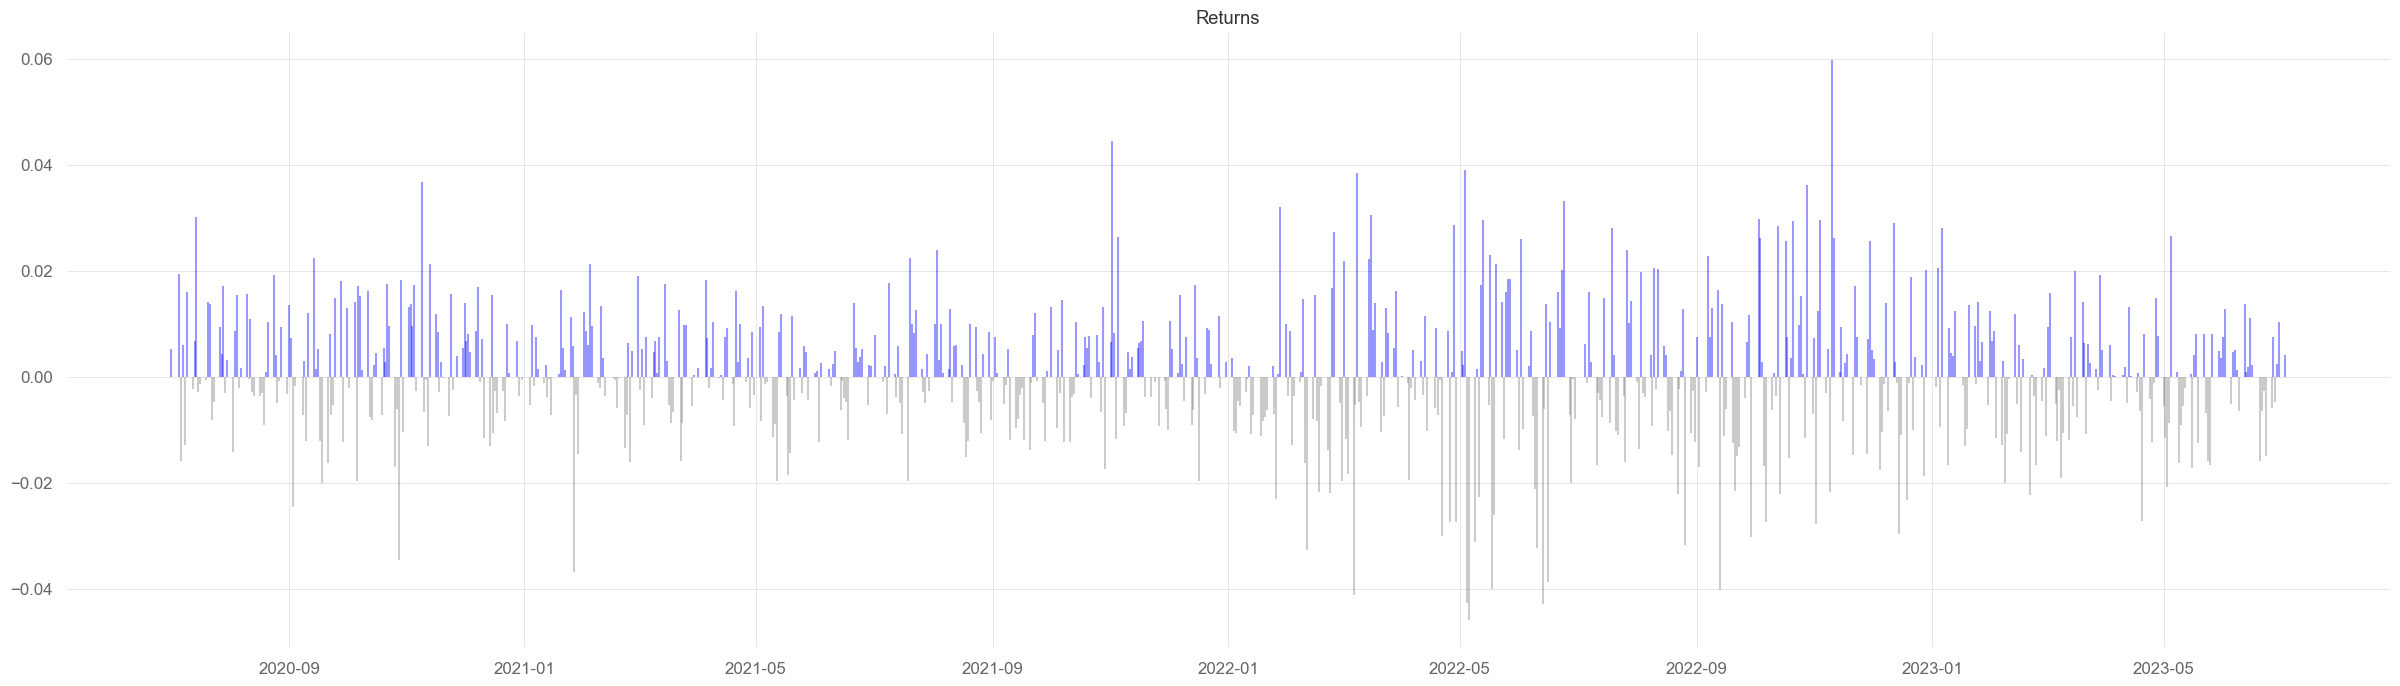

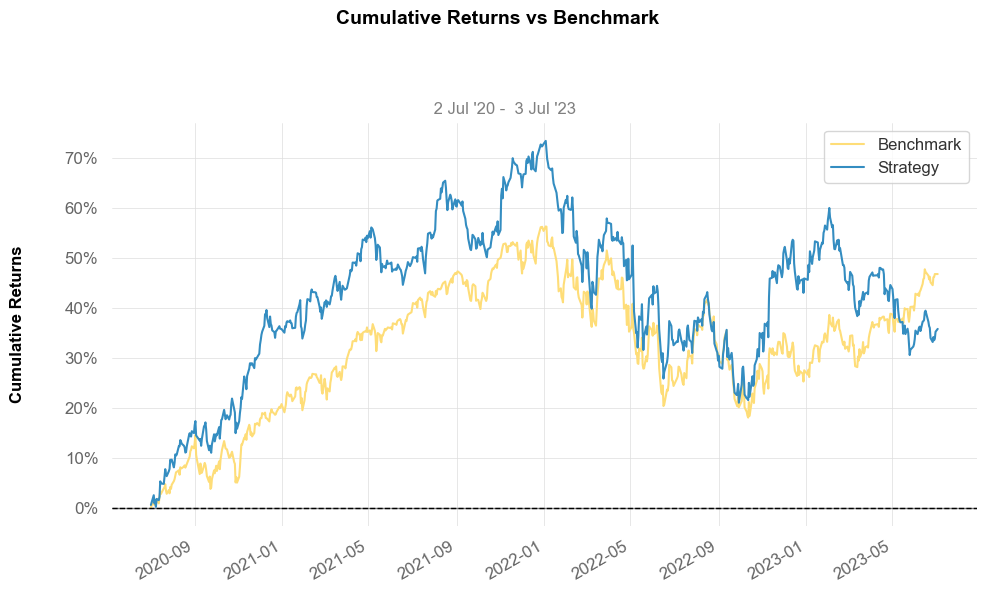

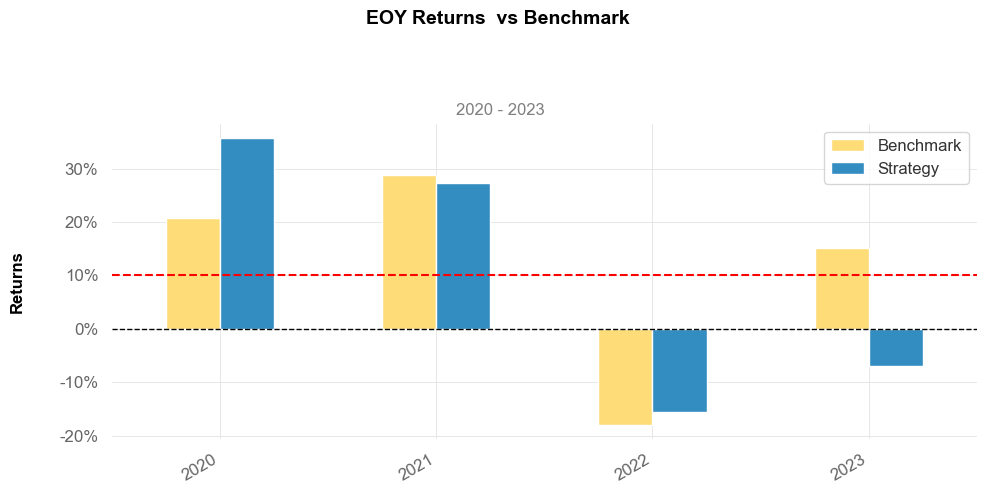

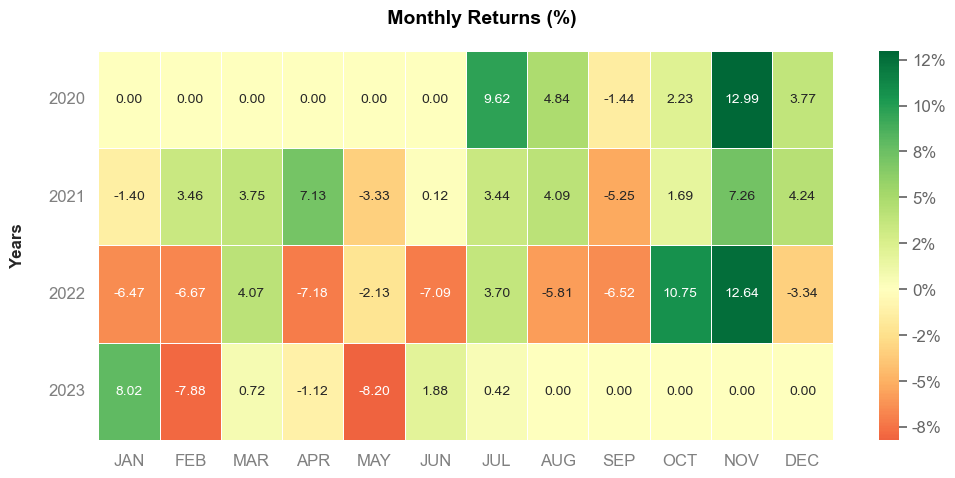

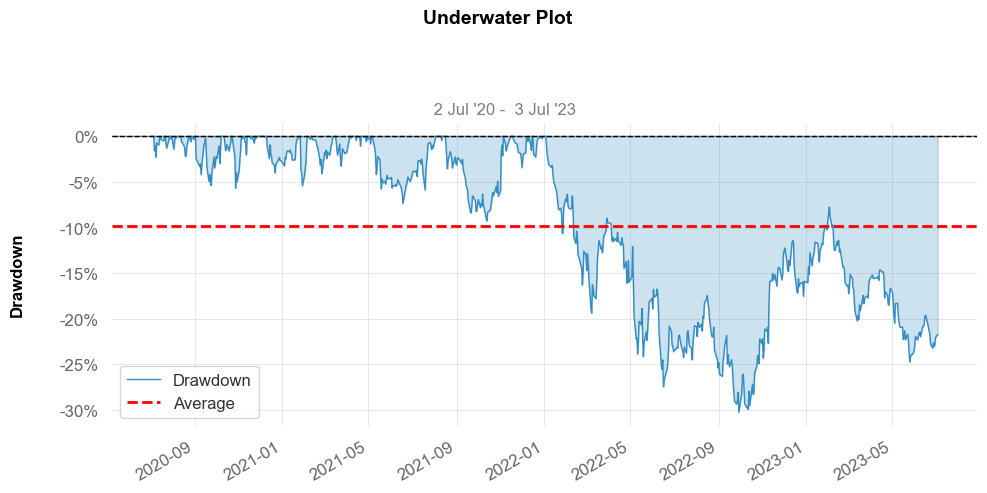

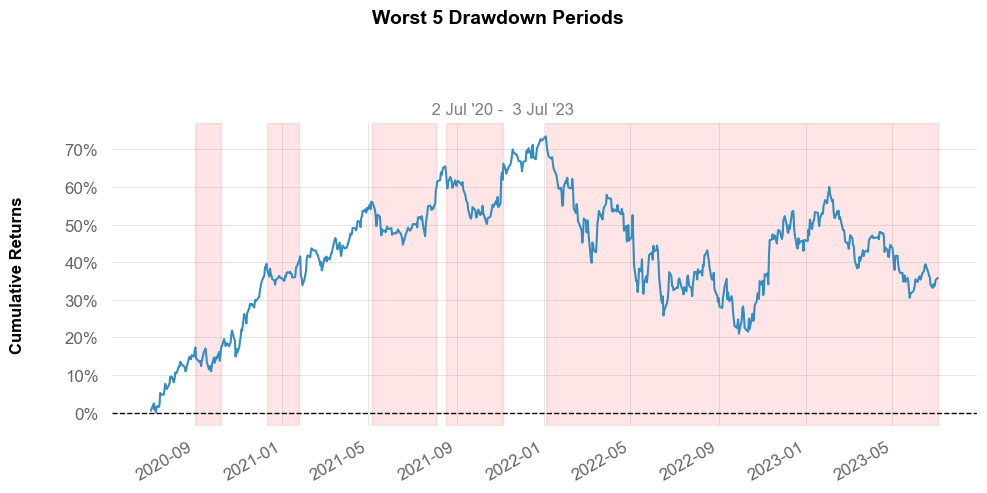

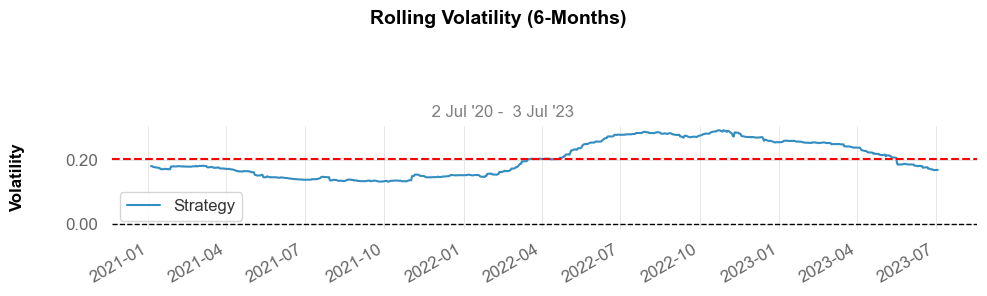

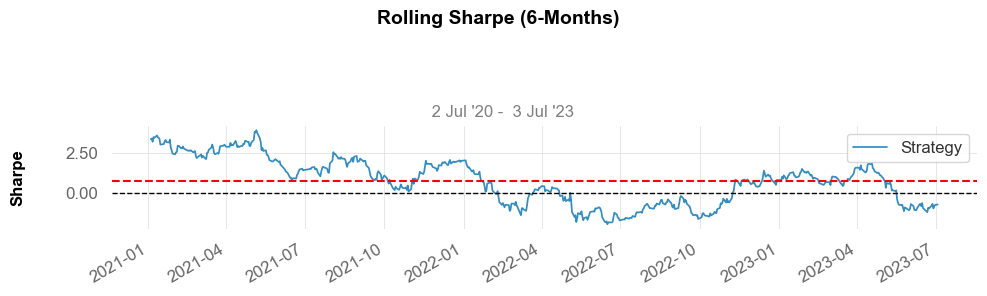

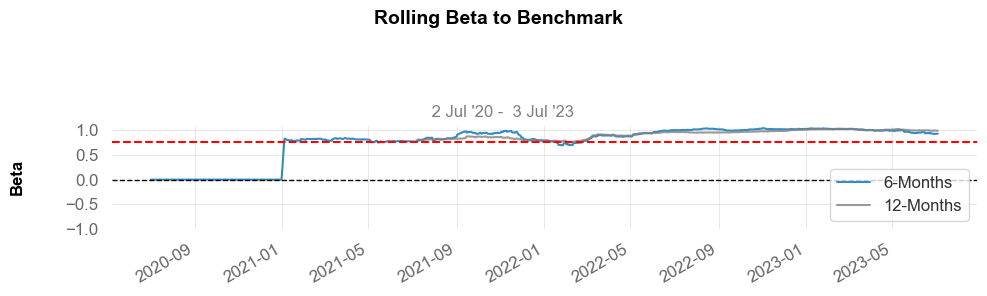

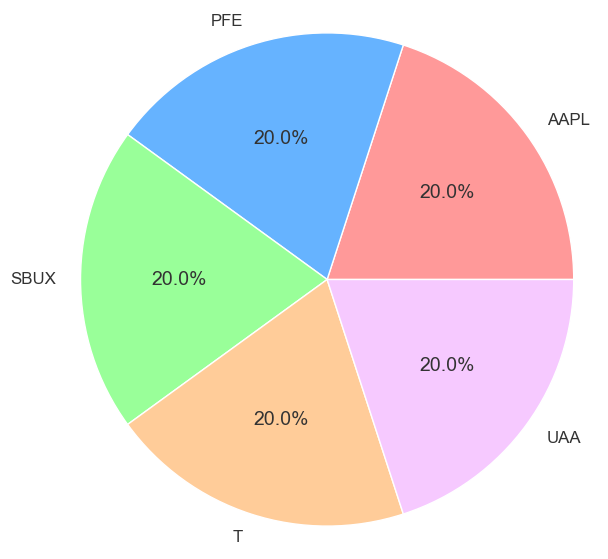

(None, None, None, None, None, None, None, None, None)

In [12]:
portfolio_tickers = list(cleaned_weights.keys()) 
portfolio_weights = list(cleaned_weights.values())

import datetime
from empyrial import empyrial, Engine
portfolio = Engine(
      start_date = "2020-7-01",
      #optimizer = "MEANVAR",
      end_date=datetime.date(2023, 6, 30),
      #max_weights=0.2,
      #max_vol = 0.20,
      rebalance = "quarterly",
      portfolio = portfolio_tickers,
      weights = portfolio_weights,
      benchmark = ["SPY"]
)
#portfolio.weights

empyrial(portfolio)

Start date: 2020-7-01
End date: 2023-06-30


,Backtest
,
Annual return,9.48%
Cumulative return,30.94%
Annual volatility,20.66 %
Winning day ratio,51.33%
Sharpe ratio,0.54
Calmar ratio,0.28
Information ratio,-0.0
Stability,0.02
Max Drawdown,-33.88 %


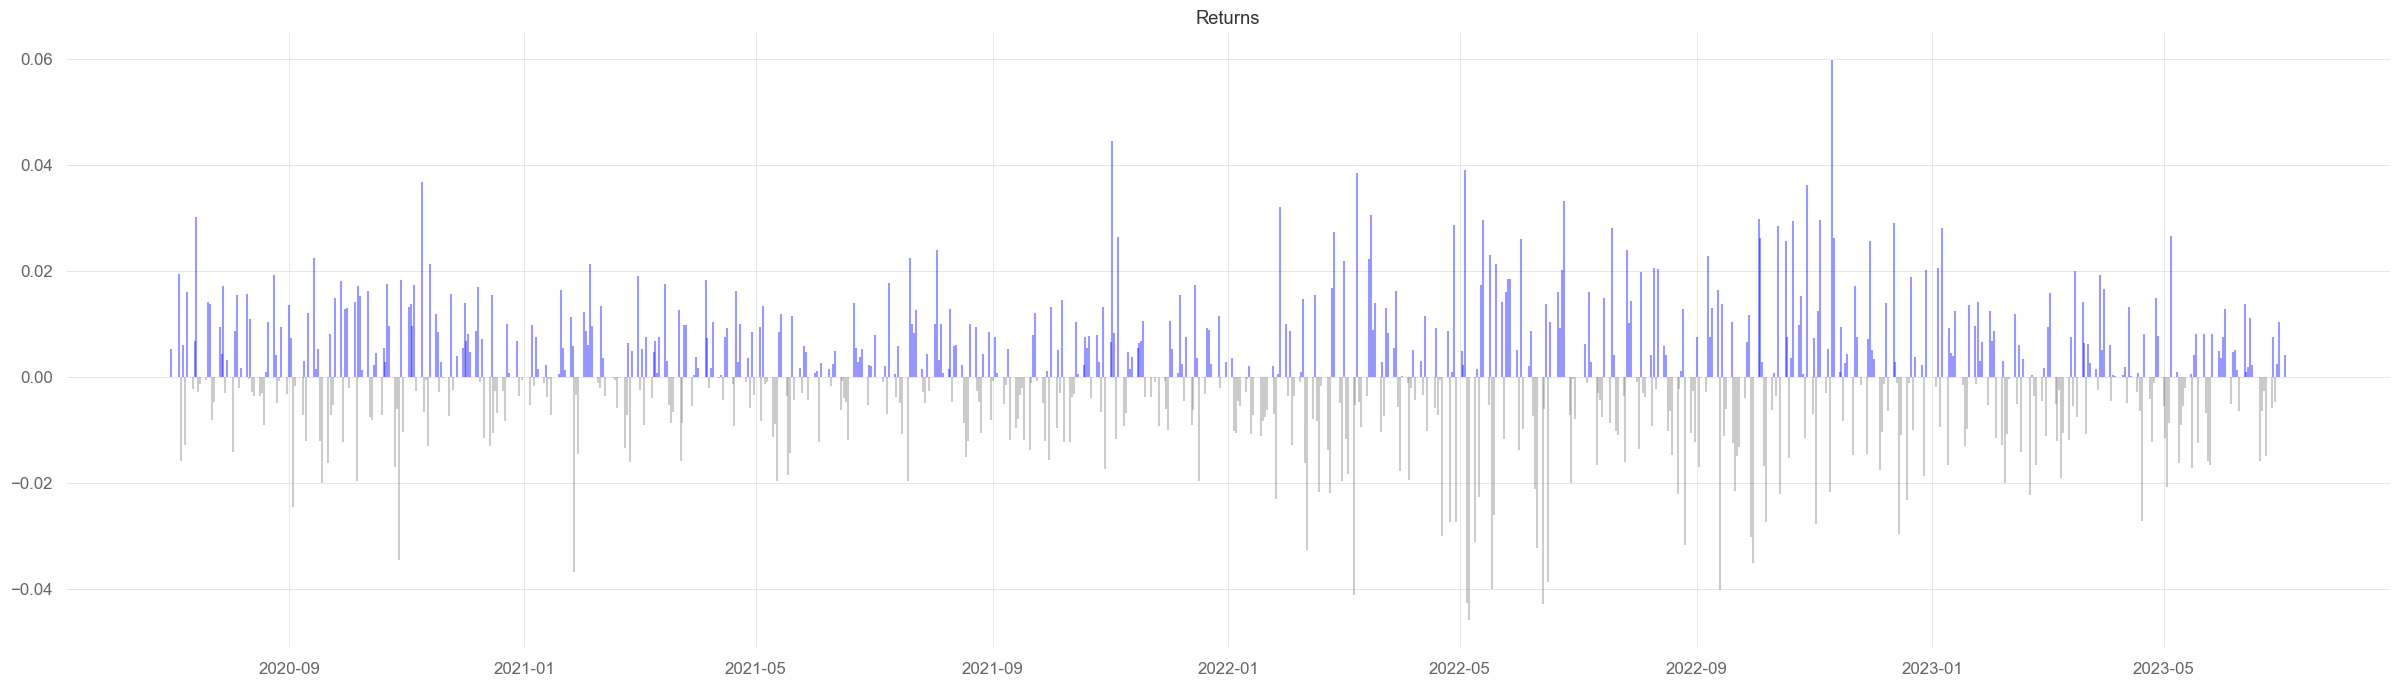

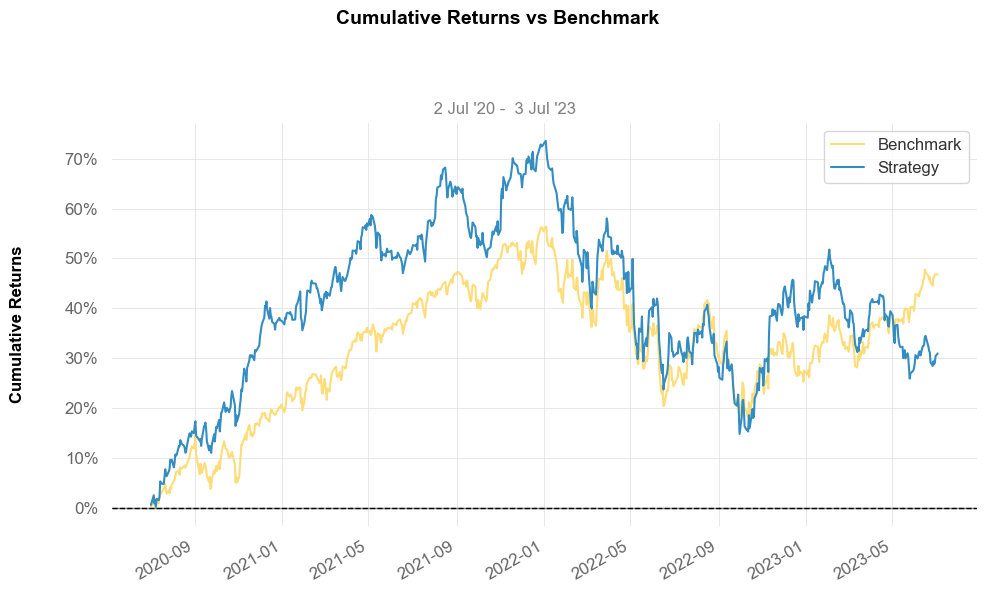

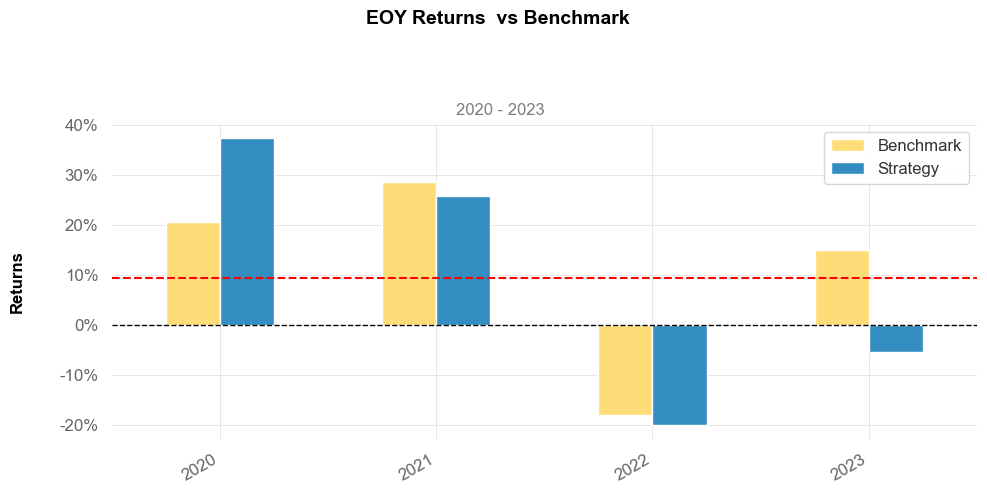

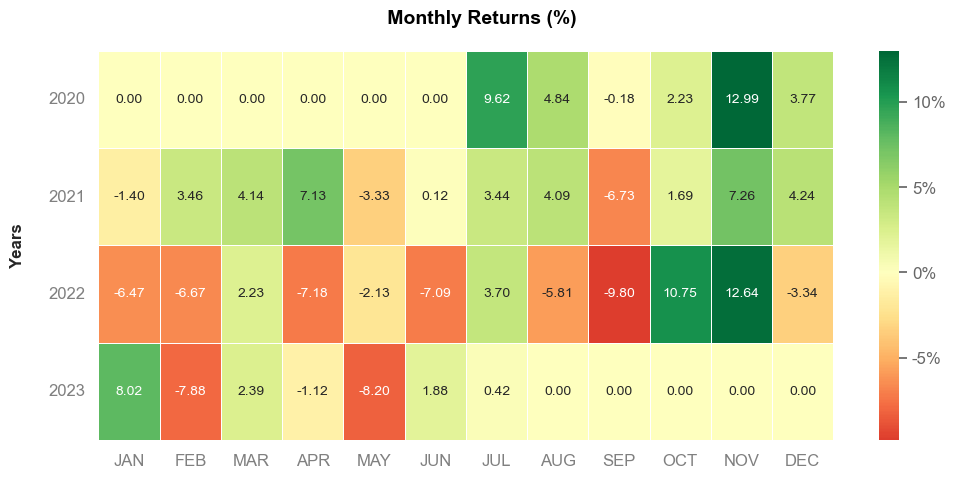

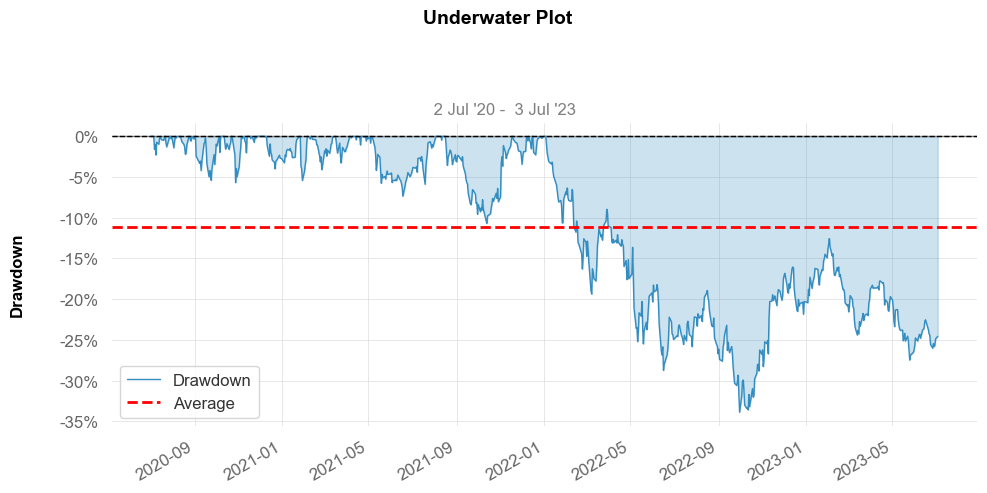

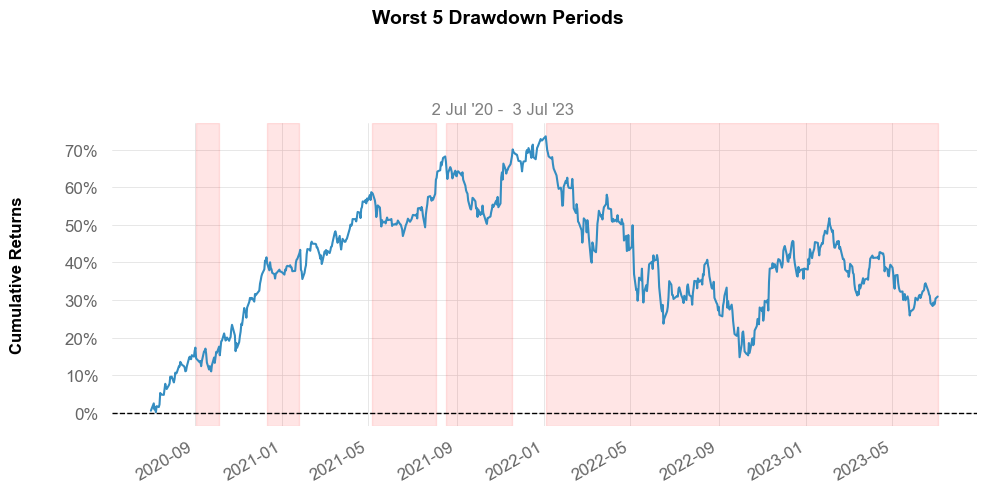

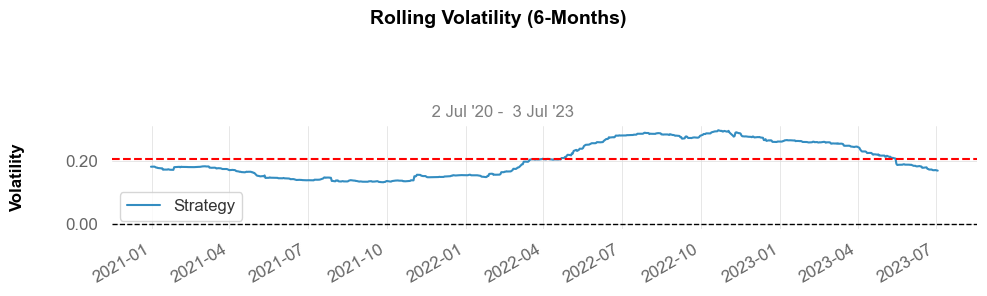

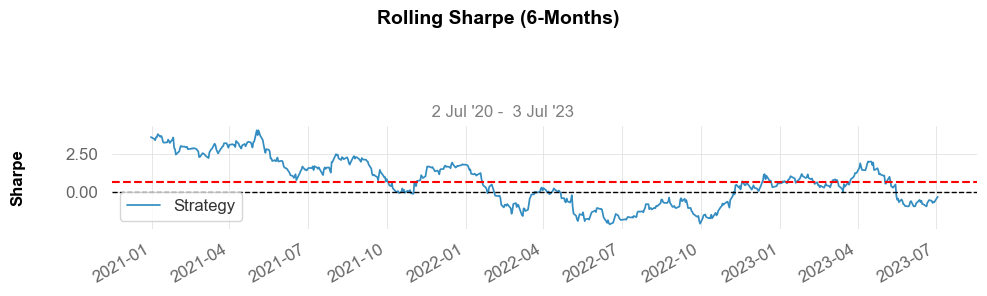

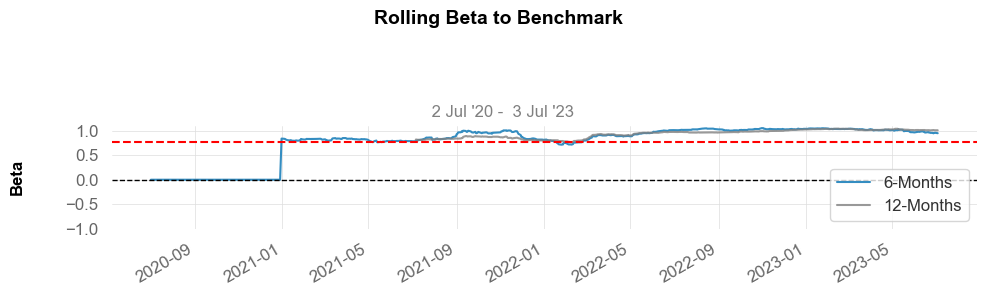

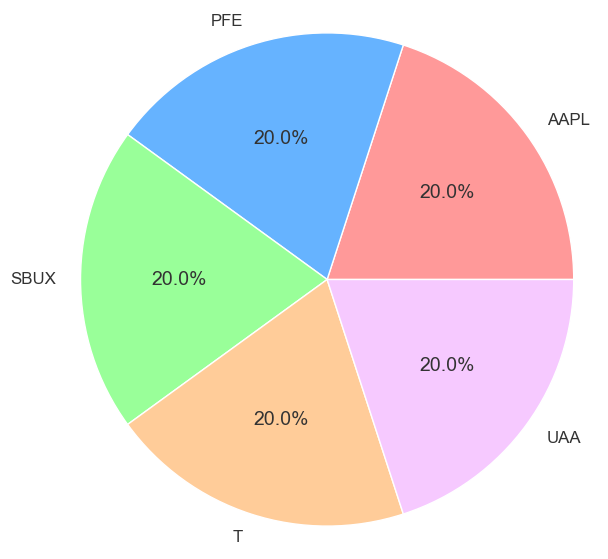

(None, None, None, None, None, None, None, None, None)

In [13]:
portfolio_tickers = list(cleaned_weights.keys()) 
portfolio_weights = list(cleaned_weights.values())

import datetime
from empyrial import empyrial, Engine
portfolio = Engine(
      start_date = "2020-7-01",
      #optimizer = "MEANVAR",
      end_date=datetime.date(2023, 6, 30),
      #max_weights=0.2,
      #max_vol = 0.20,
      rebalance = "6m",
      portfolio = portfolio_tickers,
      weights = portfolio_weights,
      benchmark = ["SPY"]
)
#portfolio.weights

empyrial(portfolio)

# 1/N model

Start date: 2020-7-01
End date: 2023-06-30


,Backtest
,
Annual return,28.18%
Cumulative return,103.24%
Annual volatility,21.56 %
Winning day ratio,52.78%
Sharpe ratio,1.26
Calmar ratio,1.06
Information ratio,0.0
Stability,0.57
Max Drawdown,-25.21 %


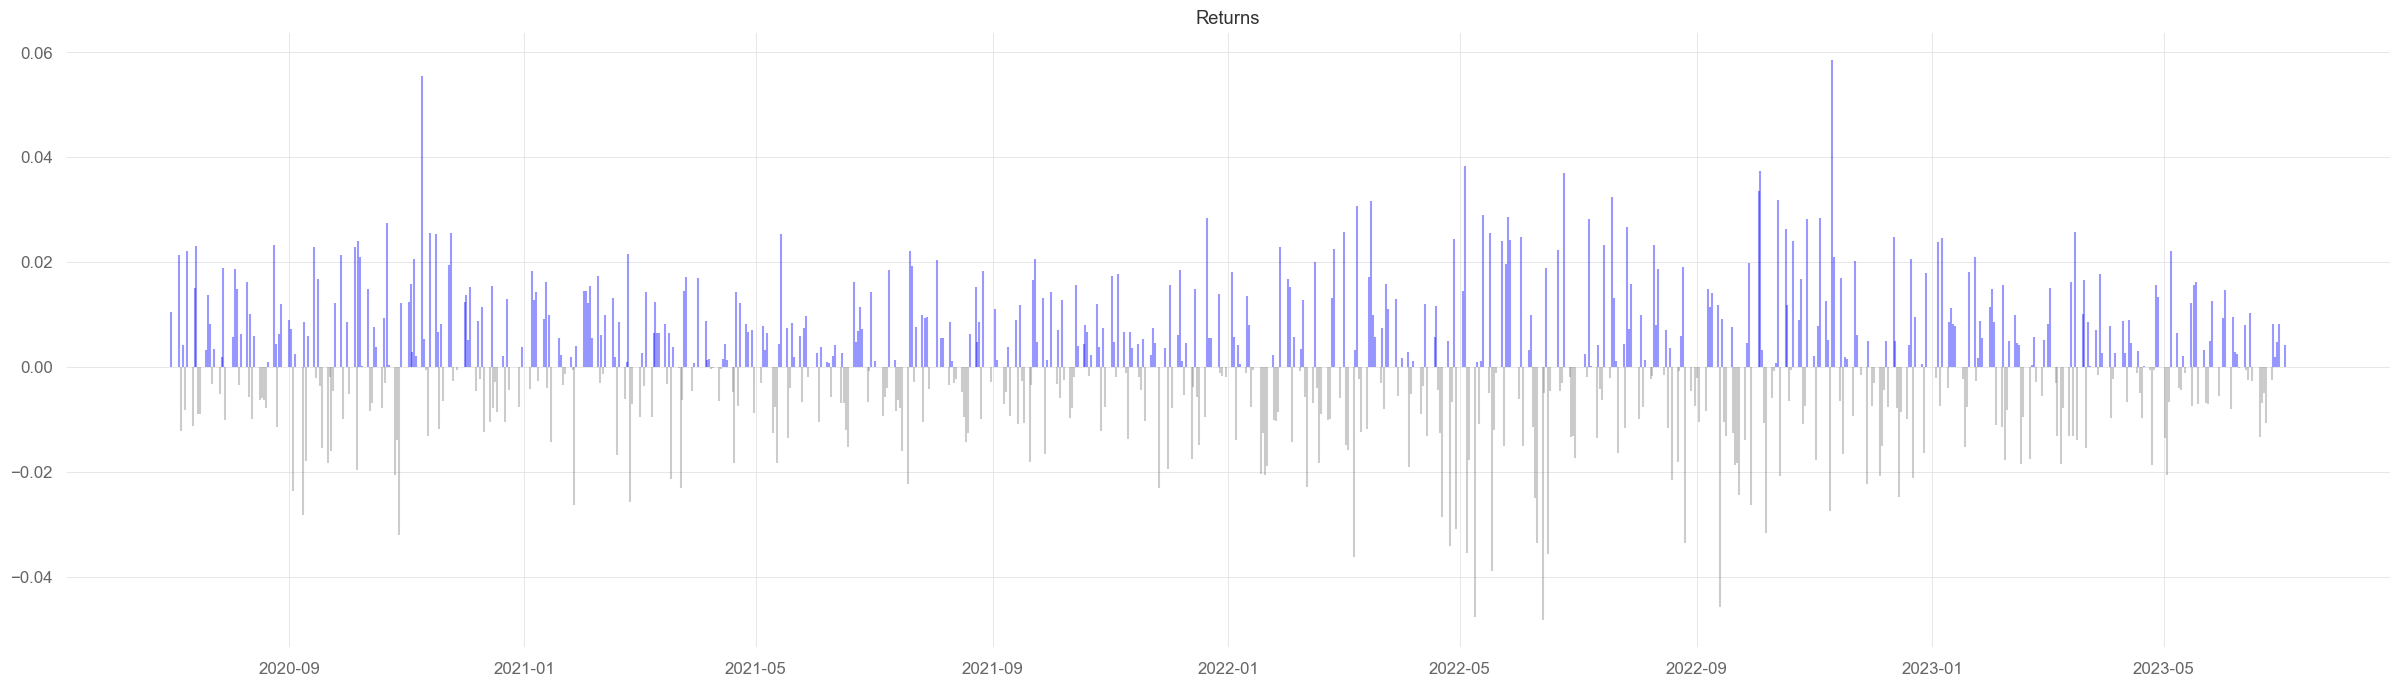

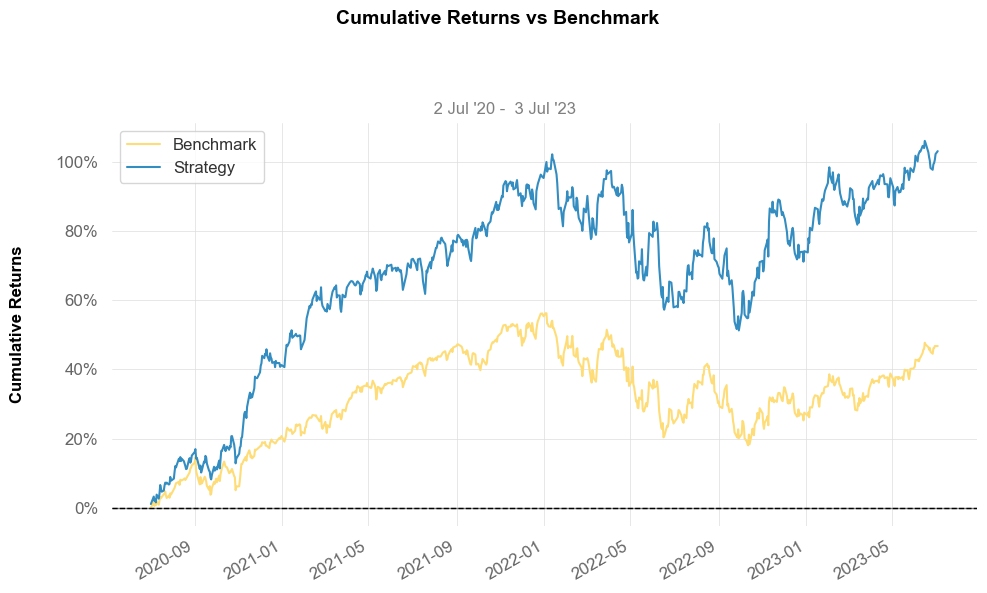

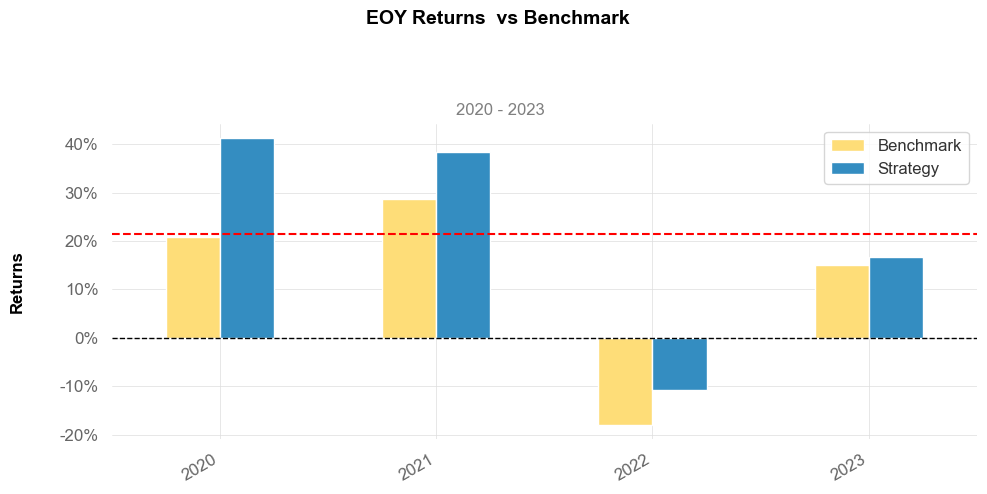

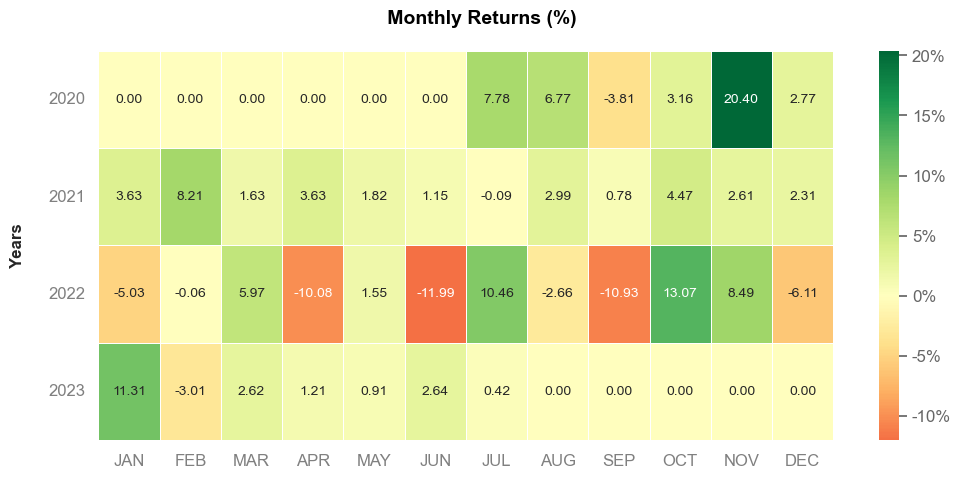

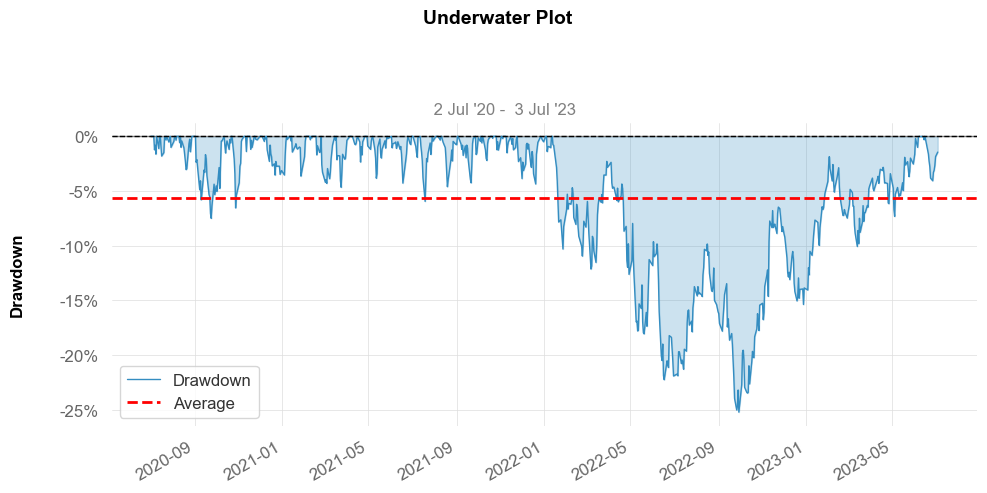

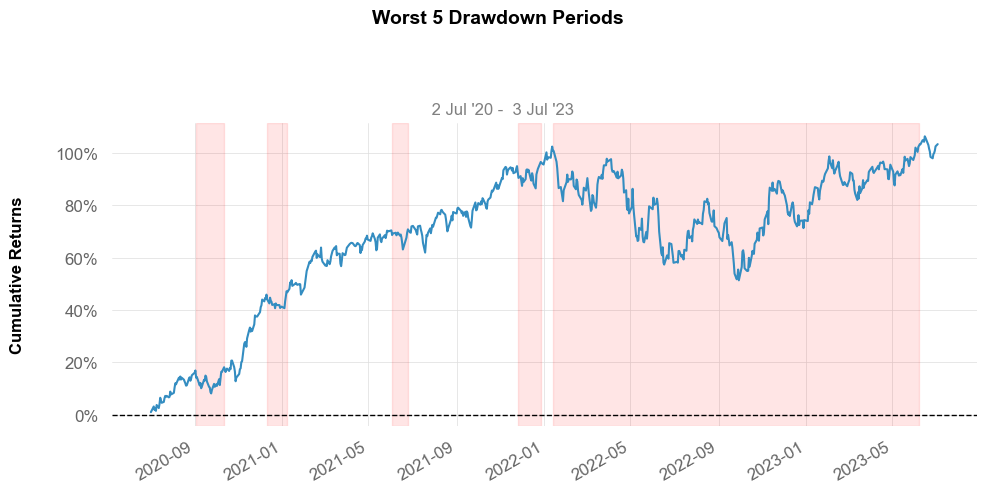

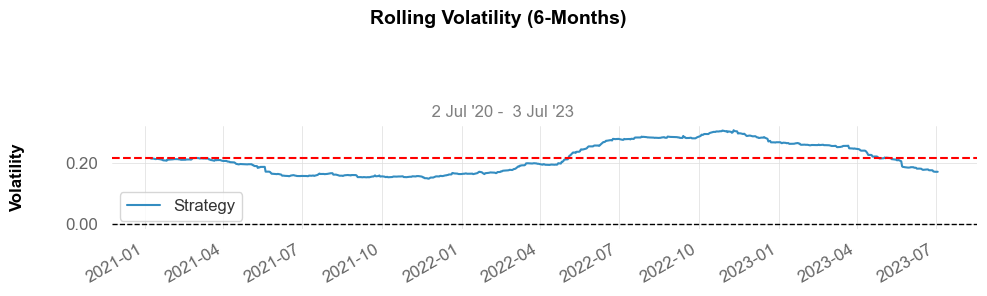

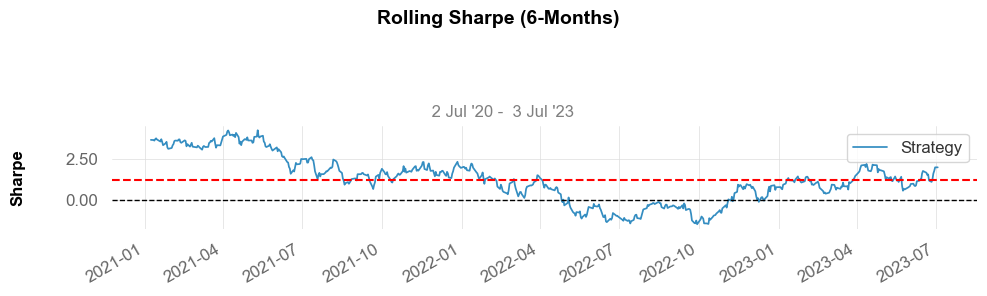

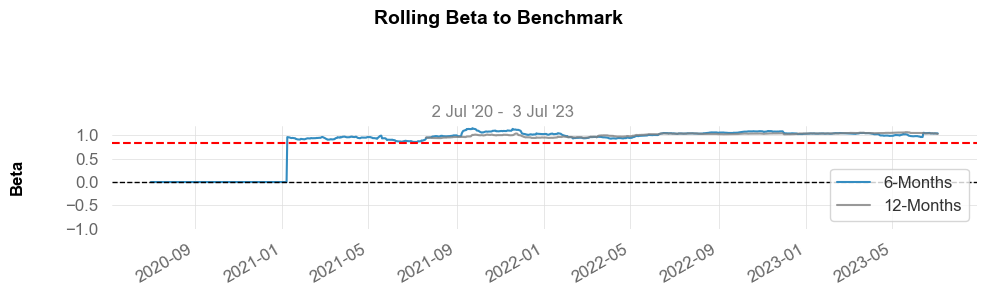

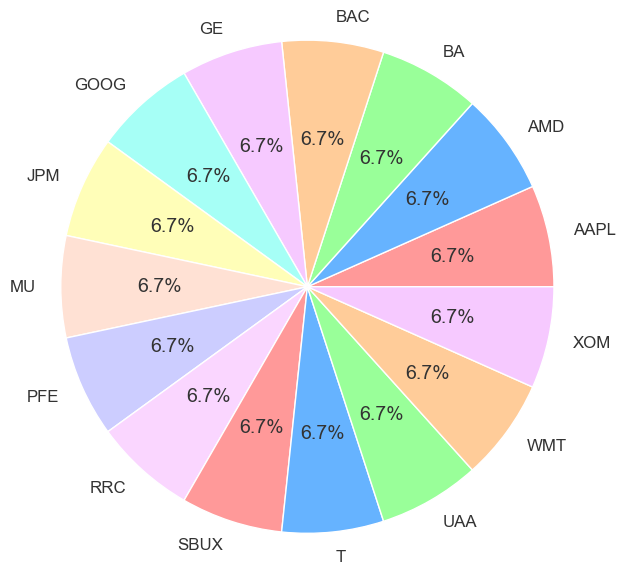

(None, None, None, None, None, None, None, None, None)

In [14]:
import datetime
from empyrial import empyrial, Engine
portfolio = Engine(
      start_date = "2020-7-01",
      #optimizer = "MEANVAR",
      end_date=datetime.date(2023, 6, 30),
      #max_weights=0.2,
      #max_vol = 0.20,
      rebalance = "monthly",
      portfolio = ['AAPL','AMD','BA','BAC', 'GE','GOOG','JPM','MU','PFE','RRC','SBUX','T','UAA','WMT','XOM'],
      #weights = portfolio_weights,
      benchmark = ["SPY"]
)
#portfolio.weights

empyrial(portfolio)

In [15]:
def utility_optimal_portfolio(risk_aversion_coeff):
    # Importing libraries
    #from pypfopt import EfficientFrontier
    #from pypfopt import risk_models
    #from pypfopt import expected_returns
    #from pypfopt import objective_functions
    #latest_prices = historical_prices.iloc[-1]
 
    # Expected Returns
    #mu = expected_returns.mean_historical_return(pf_data)
    # Expected Volatility
    #Sigma = risk_models.sample_cov(pf_data)
    ef_ = EfficientFrontier(returns, cov_matrix)  # setup
    ef_.add_objective(objective_functions.L2_reg)  # add a secondary objective
    weights = ef_.max_quadratic_utility(risk_aversion=risk_aversion_coeff, market_neutral=False)  # find the portfolio that maximizes utility
    ret,vol,sharpe_r = ef_.portfolio_performance()
    da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=10000)
    allocation, leftover = da.greedy_portfolio()
    # loop to iterate for values  
    res = dict() 
    for key in weights:  
    # rounding to K using round() 
        res[key] = round(weights[key], 2) 
    
    return "Allocation " + str(res),'Annualised Reutrn ' + str(round(ret,2)),'Annualised Volatility ' + str(round(vol,2)),'Sharpe Ratio ' + str(round(sharpe_r,2)),'Allocation ' + str(allocation),'Leftover fund ' + str(leftover) 

In [16]:
# Aggressive Investor
utility_optimal_portfolio(1)

("Allocation {'AAPL': 0.12, 'AMD': 0.0, 'BA': 0.07, 'BAC': 0.0, 'GE': 0.06, 'GOOG': 0.06, 'JPM': 0.05, 'MU': 0.04, 'PFE': 0.09, 'RRC': 0.0, 'SBUX': 0.15, 'T': 0.06, 'UAA': 0.25, 'WMT': 0.03, 'XOM': 0.03}",
 'Annualised Reutrn 0.32',
 'Annualised Volatility 0.19',
 'Sharpe Ratio 1.61',
 "Allocation {'UAA': 59, 'SBUX': 32, 'AAPL': 42, 'PFE': 37, 'BA': 6, 'GOOG': 24, 'GE': 4, 'T': 39, 'JPM': 9, 'MU': 24, 'WMT': 5, 'XOM': 5}",
 'Leftover fund 1.7810592651367188')

In [17]:
# Moderate Investor
utility_optimal_portfolio(4)

("Allocation {'AAPL': 0.12, 'AMD': 0.0, 'BA': 0.07, 'BAC': 0.0, 'GE': 0.06, 'GOOG': 0.07, 'JPM': 0.04, 'MU': 0.02, 'PFE': 0.1, 'RRC': 0.0, 'SBUX': 0.14, 'T': 0.08, 'UAA': 0.21, 'WMT': 0.05, 'XOM': 0.04}",
 'Annualised Reutrn 0.3',
 'Annualised Volatility 0.17',
 'Sharpe Ratio 1.63',
 "Allocation {'UAA': 50, 'SBUX': 31, 'AAPL': 43, 'PFE': 43, 'T': 51, 'BA': 6, 'GOOG': 25, 'GE': 4, 'WMT': 9, 'JPM': 8, 'XOM': 7, 'MU': 10}",
 'Leftover fund 4.436445236206055')

In [18]:
# Risk-Averse Investor
utility_optimal_portfolio(10)

("Allocation {'AAPL': 0.12, 'AMD': 0.0, 'BA': 0.07, 'BAC': 0.0, 'GE': 0.06, 'GOOG': 0.07, 'JPM': 0.03, 'MU': 0.0, 'PFE': 0.12, 'RRC': 0.0, 'SBUX': 0.13, 'T': 0.1, 'UAA': 0.16, 'WMT': 0.09, 'XOM': 0.05}",
 'Annualised Reutrn 0.28',
 'Annualised Volatility 0.16',
 'Sharpe Ratio 1.64',
 "Allocation {'UAA': 38, 'SBUX': 28, 'AAPL': 43, 'PFE': 49, 'T': 70, 'WMT': 14, 'BA': 6, 'GOOG': 25, 'GE': 5, 'XOM': 9, 'JPM': 5}",
 'Leftover fund 6.680051803588867')

## Markowitz with Target Volatility

In [19]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
#historical_prices = data
target_volatility = 0.2


# Calculate expected returns
#returns = expected_returns.mean_historical_return(historical_prices)
#cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
ef_tv = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))

# add a secondary objective
ef_tv.add_objective(objective_functions.L2_reg)

ef_tv.efficient_risk(target_volatility)

OrderedDict([('AAPL', 0.124930800464911),
             ('AMD', 5.6582e-12),
             ('BA', 0.0745785180291055),
             ('BAC', 2.811382e-10),
             ('GE', 0.0612975681107087),
             ('GOOG', 0.0687435295280114),
             ('JPM', 0.0537956688844077),
             ('MU', 0.0611809496961918),
             ('PFE', 0.0901576488268399),
             ('RRC', 2.258308e-10),
             ('SBUX', 0.1549980515396279),
             ('T', 0.0545162218175935),
             ('UAA', 0.1999999999840595),
             ('WMT', 0.0279741299307743),
             ('XOM', 0.0278269126751432)])

In [20]:
#plotting.plot_efficient_frontier(ef_tv, show_assets=True, show_tickers=True)

In [21]:
#  print weights
cleaned_weights = ef_tv.clean_weights()
print(cleaned_weights)

OrderedDict([('AAPL', 0.12493), ('AMD', 0.0), ('BA', 0.07458), ('BAC', 0.0), ('GE', 0.0613), ('GOOG', 0.06874), ('JPM', 0.0538), ('MU', 0.06118), ('PFE', 0.09016), ('RRC', 0.0), ('SBUX', 0.155), ('T', 0.05452), ('UAA', 0.2), ('WMT', 0.02797), ('XOM', 0.02783)])


In [22]:
#to know the expected performance of the portfolio with optimal weights w
ef_tv.portfolio_performance(verbose=True)

Expected annual return: 30.5%
Annual volatility: 18.3%
Sharpe Ratio: 1.56


(0.30498417721161186, 0.18297990702521416, 1.557461591519673)

In [23]:
# Calculate the discrete allocation of assets based on the optimal weights
#latest_prices = historical_prices.iloc[-1]  # Latest prices for the assets
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.greedy_portfolio()

In [24]:
print("Optimal Allocation:", allocation)
print("Leftover:",leftover)

Optimal Allocation: {'UAA': 48, 'SBUX': 33, 'AAPL': 44, 'PFE': 38, 'BA': 6, 'GOOG': 26, 'GE': 5, 'MU': 33, 'T': 37, 'JPM': 10, 'WMT': 4, 'XOM': 5}
Leftover: 8.117725372314453


# Find weights for different periods

In [33]:
start_date ='2015-1-1'
end_date ='2020-12-31'

# Fetch the data
import yfinance as yf
data_diff = yf.download(tickers_list,start = start_date,end = end_date)['Adj Close']

monthly_prices = data_diff.copy()
#monthly_prices['MonthNumber'] = historical_prices.index.month
#monthly_prices['YearNumber'] = historical_prices.index.year
#monthly_prices["Concatkey"] = monthly_prices['MonthNumber'].astype(str) +"-"+ monthly_prices["YearNumber"].astype(str)
#grouped_monthly_prices = monthly_prices.groupby(['Concatkey'],sort=False)
'''for month_year, group in grouped_monthly_prices:
    # Print the month number and the corresponding group data
    #print(f"Month: {month_year}")
    #print(group)
    prices_new = group
    #prices_new = prices.copy()
    prices_new = prices_new.loc[:, ~prices_new.columns.isin(['MonthNumber', 'YearNumber',' Concatkey'])]
    print(prices_new)'''
'''for month, group in monthly_prices.groupby(pd.Grouper(freq='3M')):
    # Print the month and the corresponding group data
    print(f"Month: {month}")
    print(group)
    print()'''

[*********************100%***********************]  15 of 15 completed


'for month, group in monthly_prices.groupby(pd.Grouper(freq=\'3M\')):\n    # Print the month and the corresponding group data\n    print(f"Month: {month}")\n    print(group)\n    print()'

In [35]:
# Create an empty DataFrame to store allocation results
allocation_history = pd.DataFrame(columns=tickers_list)

# Set initial portfolio value
portfolio_value = 10000

# Set rebalancing frequency (in months)
#rebalancing_frequency = 1

# Iterate over each month
for month, group in monthly_prices.groupby(pd.Grouper(freq='Y')):
    prices = group
    #prices_new = prices.copy()
    #prices_new = prices_new.loc[:, ~prices_new.columns.isin(['MonthNumber','YearNumber','Concatkey'])]
    #target_volatility = 0.2
    
    # Calculate expected returns and covariance matrix
    returns = expected_returns.mean_historical_return(prices)
    cov_matrix = risk_models.sample_cov(prices)

    # Create an instance of EfficientFrontier
    ef = EfficientFrontier(returns, cov_matrix, weight_bounds=(0, 0.2))

    #ef.add_objective(objective_functions.L2_reg)
    
    # Optimize for maximum Sharpe ratio
    weights = ef.max_sharpe()

    #ef.efficient_risk(target_volatility)
    
    # Clean the weights for assets below the lower weight bound
    cleaned_weights = ef.clean_weights()

    # Calculate the discrete allocation of assets based on the optimal weights
    #latest_prices = prices.iloc[-1]  # Latest prices for the assets
    #da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=portfolio_value)
    #allocation, _ = da.greedy_portfolio()

    # Store the allocation for the current month
    allocation_history = allocation_history.append(cleaned_weights, ignore_index=True)

# Print the allocation history
print(allocation_history)

      AAPL      WMT       MU       BA     GOOG   GE      AMD  BAC    T  \
0  0.00000  0.00000  0.00000  0.14064  0.20000  0.2  0.00000  0.0  0.2   
1  0.00000  0.20000  0.00000  0.00000  0.05237  0.0  0.20000  0.0  0.2   
2  0.17467  0.20000  0.04702  0.20000  0.10235  0.0  0.00000  0.0  0.0   
3  0.00000  0.07439  0.00000  0.20000  0.00000  0.0  0.20000  0.0  0.0   
4  0.20000  0.20000  0.00000  0.00000  0.00000  0.0  0.08314  0.0  0.2   
5  0.20000  0.20000  0.02432  0.00000  0.20000  0.0  0.20000  0.0  0.0   

       UAA      XOM     RRC  PFE      JPM     SBUX  
0  0.05936  0.00000  0.0000  0.0  0.00000  0.20000  
1  0.00000  0.14763  0.0000  0.0  0.20000  0.00000  
2  0.00000  0.00422  0.0000  0.2  0.07174  0.00000  
3  0.12561  0.00000  0.0000  0.2  0.00000  0.20000  
4  0.00000  0.00000  0.0000  0.0  0.16242  0.15444  
5  0.00000  0.00000  0.1325  0.0  0.00000  0.04317  
